In [ ]:
!pip install git+https://github.com/imanring/Cox_Hawkes_Cov.git

In [1]:
from bstpp.main import Point_Process_Model

/home/imanring/PointProcess/Cox_Hawkes/cox_hawkes/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
A = ((3,15.5),(4,16.5))
model_name = 'cox_hawkes'
model = Point_Process_Model('data/spt_data.csv',A,model=model_name,spatial_cov='data/spatial_cov.csv')

In [9]:
import pickle
pre_run = True
if pre_run:
    with open(f'output/{model_name}/output.pkl', 'rb') as f:
        output = pickle.load(f)
    model.mcmc = output['mcmc']
    model.mcmc_samples = output['samples']
else:
    model.run_mcmc()

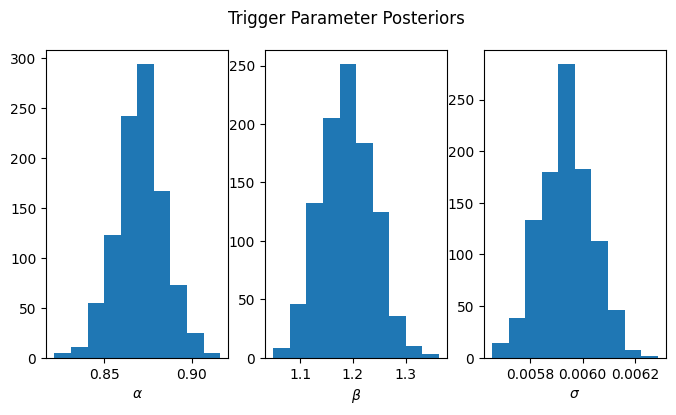

In [10]:
model.plot_trigger_posterior(f'output/{model_name}/trig_post.png')

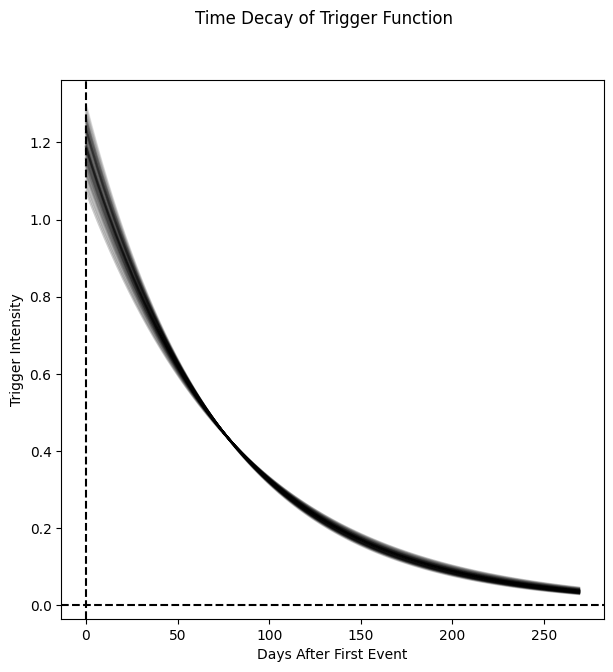

Mean trigger time: 76.9 days


In [11]:
model.plot_trigger_time_decay(f'output/{model_name}/trig_post_time_decay.png')

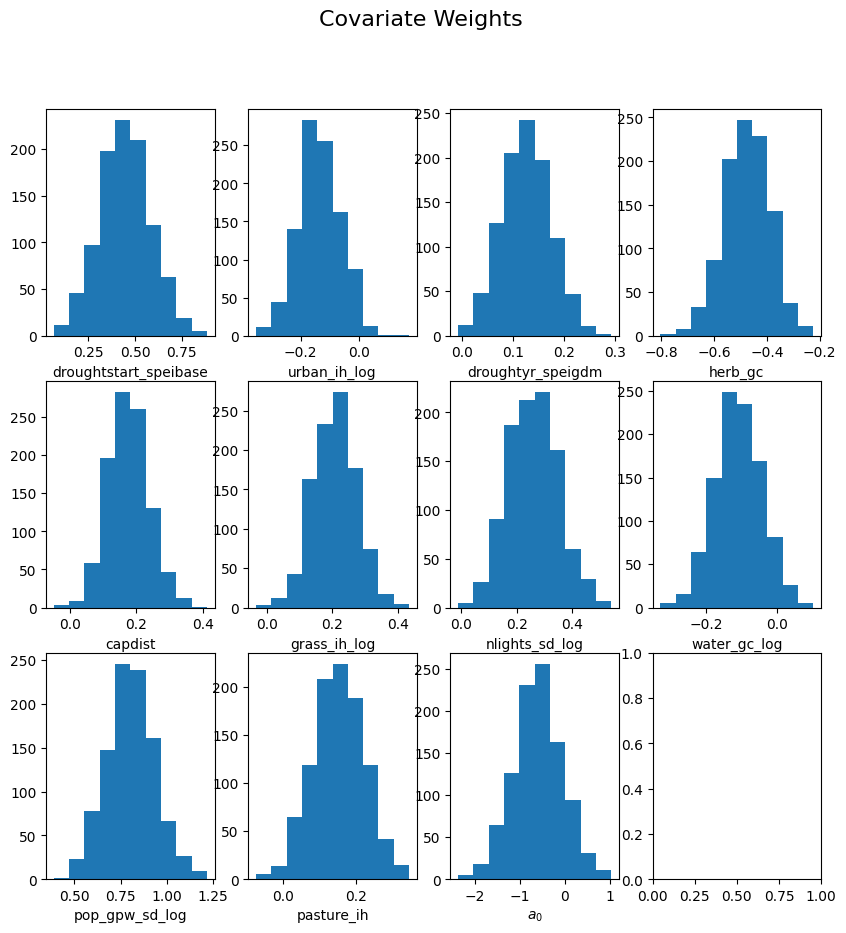

,Post Mean,Post Std,z,P>|z|,[0.025,0.975]
droughtstart_speibase,0.446949,0.137131,3.259282,1.116948e-03,0.181884,0.716398
urban_ih_log,-0.136059,0.073133,-1.860442,6.282297e-02,-0.285697,-0.003267
droughtyr_speigdm,0.126380,0.048125,2.626054,8.638120e-03,0.037987,0.223130
herb_gc,-0.476154,0.087099,-5.466815,4.581926e-08,-0.655157,-0.313144
capdist,0.175739,0.061458,2.859511,4.242943e-03,0.056233,0.302085
grass_ih_log,0.207831,0.067117,3.096530,1.958001e-03,0.076893,0.339425
nlights_sd_log,0.259852,0.088884,2.923505,3.461146e-03,0.089122,0.437412
water_gc_log,-0.108693,0.066725,-1.628962,1.033211e-01,-0.236047,0.022192
pop_gpw_sd_log,0.806426,0.129116,6.245772,4.217124e-10,0.555000,1.062594
pasture_ih,0.151504,0.069843,2.169216,3.006626e-02,0.016171,0.291939


In [14]:
model.cov_weight_post_summary(plot_file=f'output/{model_name}/cov_post_hist.png',
                              summary_file=f'output/{model_name}/cov_par_summary.csv')

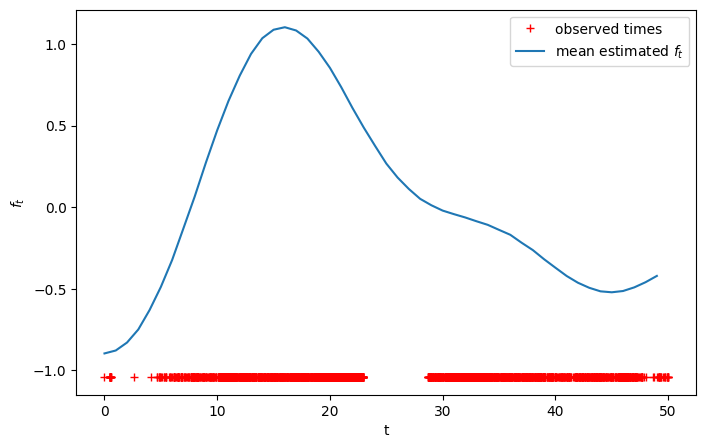

In [15]:
model.plot_temporal_background(f'output/{model_name}/temporal_gp_post_mean.png')

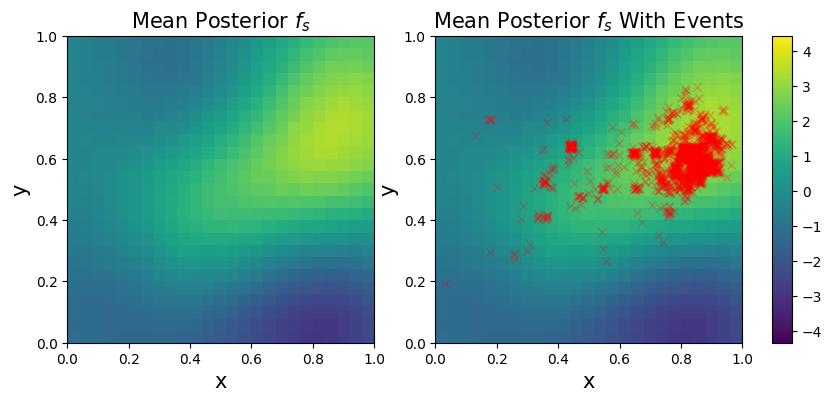

In [16]:
model.plot_spatial_background(f'output/{model_name}/spatial_gp_post_mean.png')

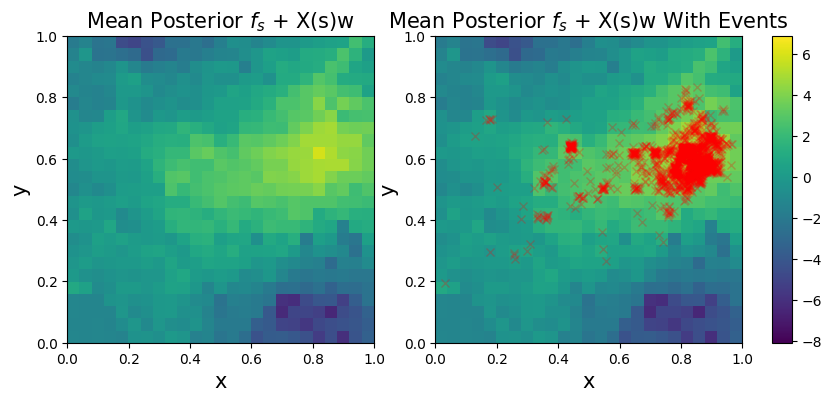

In [12]:
model.plot_spatial_background(f'output/{model_name}/spatial_gp_cov_post_mean.png',include_cov=True)